In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import gaussian_kde
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist, cosine
from scipy.ndimage import convolve1d
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from joblib import Parallel, delayed

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors
import textwrap

import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os

import seaborn as sns
import cmocean as cmocn

%matplotlib inline

In [2]:
#load QuikSCAT dataset
ds = xr.open_dataset('../../seaStateProcessing/testMatchups/rainFlagRemovedBuoyDataBadQualityRemovedMatchupAmbuguitiesAdded_waveAndGlorysAdded_manualRemovedSomeData.nc')
df = ds.to_dataframe()

df['SST-AIRT'] = df['SST (TAO)'] - df['AIRT (TAO)']
df['VSD'] = np.sqrt(df['VSDX']**2 + df['VSDY']**2)
df['VSD_DIR'] = (np.rad2deg(np.arctan2(df['VSDY'], df['VSDX'])) + 360)%360

dummy = (df['VSD_DIR']-df['mean_WDIR']+360)%360
dummy[dummy <= -180] = dummy[dummy <= -180] + 360
dummy[dummy > 180] = dummy[dummy > 180] - 360
df['VSD_DIR-mean_WDIR']  = dummy 

df['OCN_CUR'] = np.sqrt(df['uo']**2 + df['vo']**2)
df['OCN_CUR_DIR'] = (np.rad2deg(np.arctan2(df['vo'], df['uo'])) + 360)%360
dummy = (df['OCN_CUR_DIR']-df['mean_WDIR']+360)%360
dummy[dummy <= -180] = dummy[dummy <= -180] + 360
dummy[dummy > 180] = dummy[dummy > 180] - 360
df['OCN_CUR_DIR-mean_WDIR']  = dummy 


dummy = (df['VMDR_WW']-df['mean_WDIR'] +360)%360
dummy[dummy <= -180] = dummy[dummy <= -180] + 360
dummy[dummy > 180] = dummy[dummy > 180] - 360
df['VMDR_WW-mean_WDIR'] = dummy

dummy = (df['VPED']-df['mean_WDIR']+360)%360
dummy[dummy <= -180] = dummy[dummy <= -180] + 360
dummy[dummy > 180] = dummy[dummy > 180] - 360
df['VPED-mean_WDIR'] = dummy

dummy = (df['VMDR']-df['mean_WDIR'] +360)%360
dummy[dummy <= -180] = dummy[dummy <= -180] + 360
dummy[dummy > 180] = dummy[dummy > 180] - 360
df['VMDR-mean_WDIR'] = dummy

dummy = (df['VMDR_SW1'] - df['mean_WDIR'] +360)%360
dummy[dummy <= -180] = dummy[dummy <= -180] + 360
dummy[dummy > 180] = dummy[dummy > 180] - 360
df['VMDR_SW1-mean_WDIR'] = dummy

dummy = (df['VMDR_SW2']-df['mean_WDIR'] +360)%360
dummy[dummy <= -180] = dummy[dummy <= -180] + 360
dummy[dummy > 180] = dummy[dummy > 180] - 360
df['VMDR_SW2-mean_WDIR'] = dummy

df = df.rename(columns={
    'nudge_wind_speed': 'model_speed',
    'nudge_wind_direction': 'model_dir'
})

dummy = (df['model_dir']-df['mean_WDIR']+360)%360
dummy[dummy <= -180] = dummy[dummy <= -180] + 360
dummy[dummy > 180] = dummy[dummy > 180] - 360
df['model_dir-mean_WDIR']  = dummy 
df['model_speed-mean_WSPD_10N'] = df['model_speed']-df['mean_WSPD_10N']

df_orig = df.copy()

In [3]:
import joblib
classifier = joblib.load("../../seaStateProcessing/deepLearning/random_forest_goodBadMatchup.joblib")
#classifier = joblib.load("../../seaStateProcessing/deepLearning/random_forest_goodBadMatchup_firstNeuralNet.joblib")

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
data = df
features = ['std_cosWDIR',
  'SST-AIRT',
  'std_sinWDIR',
  'VSD_DIR-mean_WDIR',
  'std_WSPD_10N',
  'WSPD_10N (TAO)',
  'VSDY',
  'VSDX',
  'std_AIRT',
  'VHM0_WW',
  'RELH (TAO)']

X = data[features]

y_pred = classifier.predict(X)

In [5]:
ds

<xarray.Dataset>
Dimensions:                                   (count: 264416)
Coordinates:
  * count                                     (count) int64 0 1 ... 295512
Data variables: (12/121)
    WDIR (TAO)                                (count) float32 140.6 ... 143.2
    WDIR_QC                                   (count) float32 2.0 2.0 ... 2.0
    WDIR_DM                                   (count) |S1 b'D' b'D' ... b'D'
    WSPD (TAO)                                (count) float32 6.79 5.46 ... 4.23
    WSPD_QC                                   (count) float32 2.0 2.0 ... 2.0
    WSPD_DM                                   (count) |S1 b'D' b'D' ... b'D'
    ...                                        ...
    VWND_DIFF (QuikSCAT - TAO)                (count) float64 -0.1175 ... 1.579
    WDIR_DIFF (QuikSCAT - TAO) absolute       (count) float64 1.2 ... -30.95
    cos(WDIR_DIFF (QuikSCAT - TAO)) absolute  (count) float64 0.9998 ... 0.8576
    sin(WDIR_DIFF (QuikSCAT - TAO)) absolute  (count) float64 0.02094 ... -0....
    UWND_DIFF (QuikSCAT - TAO) absolute       (count) float64 -0.07678 ... 1.936
    VWND_DIFF (QuikSCAT - TAO) absolute       (count) float64 -0.1377 ... 1.689

In [6]:
selectX = ['WSPD_DIFF (QuikSCAT - TAO)',
          'cos(WDIR_DIFF (QuikSCAT - TAO))',
          'sin(WDIR_DIFF (QuikSCAT - TAO))']


X = df[selectX]

normX = (X - X.mean(axis=0))/ X.std(axis=0)

# kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
# df['label'] = kmeans.labels_

dbscan = DBSCAN(eps=0.15, min_samples= 500)
df['label'] = dbscan.fit_predict(normX)

In [7]:
ds['predicted_label'] = xr.DataArray(y_pred, 
                                     dims = ['count'],
                                     attrs = {'long_name':'good-bad (0 bad 1 good) matchup flag based on Random Forest trained on QuikSCAT matchup data'})

ds['DBSCAN_label'] = xr.DataArray(df['label'].to_numpy() + 1, 
                                     dims = ['count'],
                                     attrs = {'long_name':'good-bad (0 bad 1 good) matchup flag based on DBSCAN (eps=0.12, min_samples= 500)'})
ds.to_netcdf('../../seaStateProcessing/testMatchups/QuikSCAT_waveAndGlorysAdded_randomForestClassification.nc')

In [8]:
df['predicted_label'] = y_pred


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

Text(0.1, 0.95, 'B')

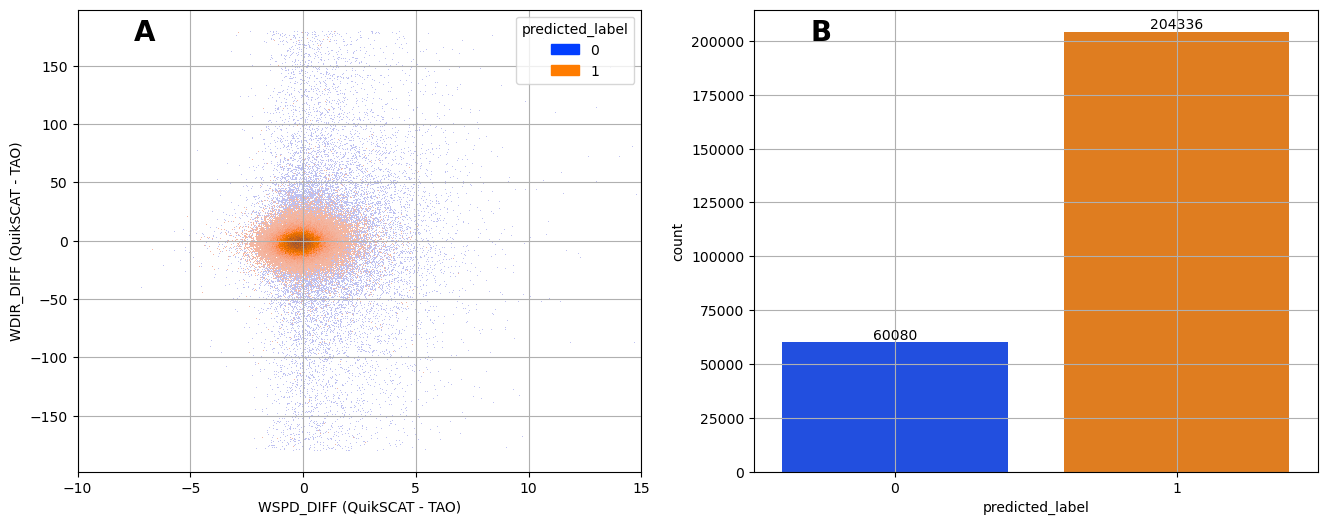

In [9]:

fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'WSPD_DIFF (QuikSCAT - TAO)'
ylabel = 'WDIR_DIFF (QuikSCAT - TAO)'

s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10, 
                hue='predicted_label', common_norm=True, #cbar = True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(df, x='predicted_label',palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
#ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


#plt.savefig('PDF_byCluster_10min.png', dpi=100)

In [10]:
goodBad = np.array(['good' for i in range(len(df))])
print(len(goodBad))
mask = df['label'].isin([-1])
goodBad[mask] = 'bad'
df['GoodBad'] = goodBad

def getGoodBad(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:    
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        return f' {goodCount:3.0f},{badCount:3.0f}'
    else:
        return ''

def getBadPercent(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    
    if isPresent:
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        
        return badCount
    else:
        return -999

def getCount(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        count = len(subDF) #.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        return count
    else:
        return -999

264416


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

0.18871399612731454


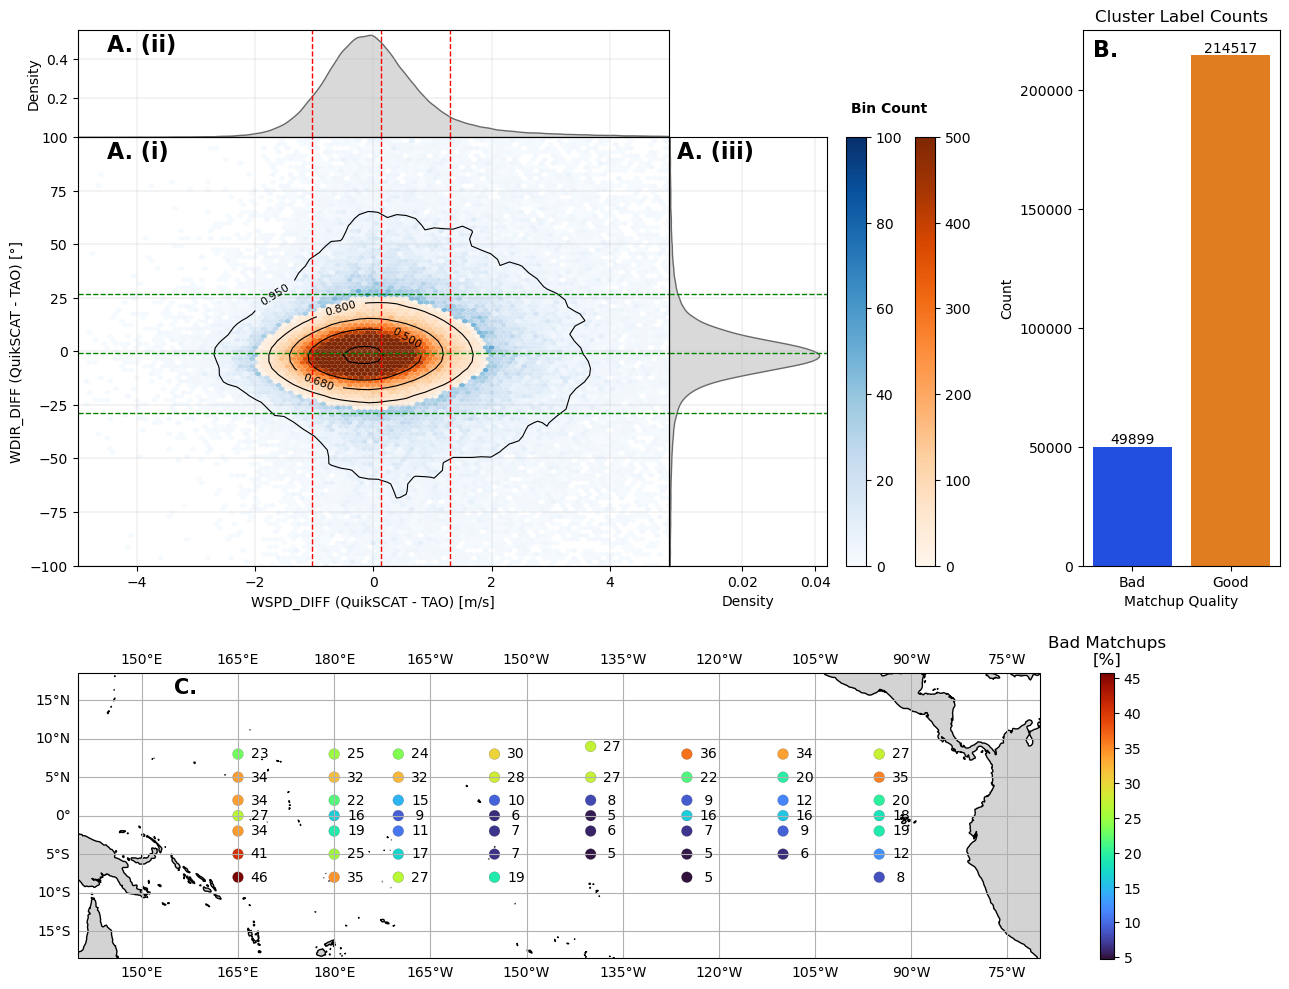

In [11]:
xlabel = 'WSPD_DIFF (QuikSCAT - TAO)'
ylabel = 'WDIR_DIFF (QuikSCAT - TAO)'

# Compute mean and std
mu_speed = df[xlabel].mean()
std_speed = df[xlabel].std()
mu_dir = df[ylabel].mean()
std_dir = df[ylabel].std()

# Create overall figure
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(13, 10))
#gs = gridspec.GridSpec(3, 8, width_ratios=[3, 0.8, 0.1, 0.1, 0.25, 0.1, 0.75, 1], height_ratios=[0.75, 3, 0.75 ], wspace=0, hspace=0)
gs = gridspec.GridSpec(4, 8, width_ratios=[3, 0.8, 0.1, 0.1, 0.25, 0.1, 0.75, 1], height_ratios=[0.75, 3, 0.75, 2], wspace=0, hspace=0)

# Joint and marginals (LEFT)
ax_joint = fig.add_subplot(gs[1, 0])
ax_marg_x = fig.add_subplot(gs[0, 0], sharex=ax_joint)
ax_marg_y = fig.add_subplot(gs[1, 1], sharey=ax_joint)
ax_cb1 = fig.add_subplot(gs[1,3])
ax_cb2 = fig.add_subplot(gs[1,5])

# Countplot (RIGHT)
ax_count = fig.add_subplot(gs[0:2, -1])  # spans both rows

# -------------------------
# 1. JOINT HISTOGRAM + KDE

colors = [plt.cm.Blues, plt.cm.Oranges]
hexcounts = [100, 100]
x_min, x_max, y_min, y_max = -5, 5, -100, 100
vmins = [0, 0]
vmaxs = [100, 500]
numcontours = 5

for i, (label, ax, ax_cb) in enumerate(zip([-1, 0], [ax_joint, ax_joint], [ax_cb1, ax_cb2])):
    df_label = df[df['label'] == label]

    hb = ax.hexbin(
        x=df_label[xlabel],
        y=df_label[ylabel],
        gridsize=hexcounts[i],
        cmap=colors[i],
        mincnt=1,
        linewidths=0.01,
        edgecolors=(0, 0, 0, 0.01),
        vmin=vmins[i],            # ← custom lower limit
        vmax=vmaxs[i],             # ← custom upper limit
        extent=(x_min, x_max, y_min, y_max)
    )

    # Extract colorbar for this label
    cbar = fig.colorbar(hb, cax=ax_cb)
    
#cbar.set_label("Bin Count")
cbar.ax.text(
    0.6, 1.05,                        # x=50% of width, y=just above the top
    "Bin Count",                     # your label
    ha='right', va='bottom',        # horizontal center, baseline aligned
    fontsize=10, fontweight='bold',  # optional styling
    transform=cbar.ax.transAxes      # relative to colorbar axis
)

# Create the Joint PDF plot and capture the returned QuadContourSet object
# KDE Grid resolution
nx, ny = 64, 64

# Data
x = df[xlabel].values
y = df[ylabel].values
xy = np.vstack([x, y])

# KDE with specified bandwidth
kde = gaussian_kde(xy, bw_method=0.1)

# Grid over which to evaluate
xx, yy = np.mgrid[x_min:x_max:nx*1j, y_min:y_max:ny*1j]
grid_coords = np.vstack([xx.ravel(), yy.ravel()])
z = kde(grid_coords).reshape(xx.shape)

# Normalize z to make it a probability surface (area ≈ 1)
dx = (x_max - x_min) / nx
dy = (y_max - y_min) / ny
z_prob = z / z.sum() #/ (dx * dy)

# Flatten and sort to get cumulative distribution
z_flat = z_prob.flatten()
z_sorted = np.sort(z_flat)[::-1]  # 🔄 descending order
z_cumsum = np.cumsum(z_sorted)

# Desired probability masses for contours
mass_levels = [0.1, 0.5, 0.68, 0.8, 0.95]
mass_levels.reverse()
levels = [z_sorted[np.searchsorted(z_cumsum, mass)] for mass in mass_levels]


#levels.sort()
# Plot contours
contour = ax_joint.contour(xx, yy, z_prob, levels=levels, colors='black', linewidths=0.8)

# Label with probability instead of density
fmt = {}
for l, s in zip(contour.levels, mass_levels):
    fmt[l] = f"{s:.3f}"  # show enclosed probability

#fmt = {level: f"{mass:.3f}" for level, mass in zip(levels, mass_levels)}

ax_joint.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=8)
# # Add labels to the contour lines
# ax_joint.clabel(contour, inline=True, fontsize=8, fmt="%.2f")

# 2. MARGINAL KDEs
sns.kdeplot(data=df, x=xlabel, fill=True, color = 'dimgrey',legend=False, ax=ax_marg_x, clip = (x_min, x_max) , cut = 0, bw_adjust=0.5 )
sns.kdeplot(data=df, y=ylabel, fill=True, color = 'dimgrey',legend=False, ax=ax_marg_y, clip = (y_min, y_max) , cut = 0, bw_adjust=0.5 )

# Remove marginal axis ticks
ax_marg_x.tick_params(bottom=False, labelbottom=False)
ax_marg_y.tick_params(left=False, labelleft=False)

# Add ±1σ lines
for x in [mu_speed - std_speed, mu_speed, mu_speed + std_speed]:
    ax_joint.axvline(x, color='red', linestyle='--', linewidth=1)
    ax_marg_x.axvline(x, color='red', linestyle='--', linewidth=1)  
    ax_marg_x.set_yticks([0.2,0.4])

for y in [mu_dir - std_dir, mu_dir, mu_dir + std_dir]:
    ax_joint.axhline(y, color='green', linestyle='--', linewidth=1)
    ax_marg_y.axhline(y, color='green', linestyle='--', linewidth=1)
    ax_marg_y.set_xticks([0.02,0.04])


# Axis labels
ax_joint.set_xlabel(xlabel + ' [m/s]')
ax_joint.set_ylabel(ylabel + " [°]")
ax_marg_x.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax_marg_y.tick_params(axis='y', which='both', left=False, labelleft=False)
ax_marg_x.set_xlabel(None)
ax_marg_y.set_ylabel(None)

# Label the panel
ax_joint.text(0.05, 0.95, 'A. (i)', transform=ax_joint.transAxes, fontsize=16, weight='bold')
ax_marg_x.text(0.05, 0.80, 'A. (ii)', transform=ax_marg_x.transAxes, fontsize=16, weight='bold')
ax_marg_y.text(0.05, 0.95, 'A. (iii)', transform=ax_marg_y.transAxes, fontsize=16, weight='bold')

# -------------------------
# 3. COUNTPLOT
s = sns.countplot(data=df, x='label', palette='bright', ax=ax_count)
for container in s.containers:
    s.bar_label(container)
ax_count.set_title("Cluster Label Counts")
#ax_count.set_xticks([-1, 0])                    # positions (the actual cluster labels)
ax_count.set_xticklabels(["Bad", "Good"])       # the new labels shown on the axis
ax_count.set_xlabel("Matchup Quality")
ax_count.set_ylabel("Count")
ax_count.text(0.05, 0.95, 'B.', transform=ax_count.transAxes, fontsize=16, weight='bold')

# Final adjustments

ax_joint.set_xlim(x_min, x_max)
ax_joint.set_ylim(y_min,  y_max)
ax_joint.grid(lw = 0.2)

ax_marg_x.set_xlim(x_min, x_max)
ax_marg_x.grid(lw = 0.2)

ax_marg_y.set_ylim(y_min,  y_max)
ax_marg_y.grid(lw = 0.2)

######################################################################################################################

import cartopy.crs as ccrs
import cartopy.feature as cfeature 
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
dotSize = 60
slw = 0.1

latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

ax = fig.add_subplot(gs[3,:], projection=ccrs.PlateCarree(central_longitude=180))
ax.set_aspect(1.2)

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)


ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
gridlines.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gridlines.xformatter = LONGITUDE_FORMATTER
ax.coastlines()
plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    if txt != '': 
        badPercent = getBadPercent(lat, lon, df)
        #print(badPercent)
        txt = f'{badPercent:2.0f}'
        ax.text(xpos+2, lat-0.5, txt)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, badPercent]])), axis = 0)

x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.turbo)    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Bad Matchups\n[%]')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'C. ', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


plt.tight_layout()

#plt.savefig('clustering_QuikSCAT.pdf', dpi=100)
print(len(df.loc[df['label'] == -1])/len(df))

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

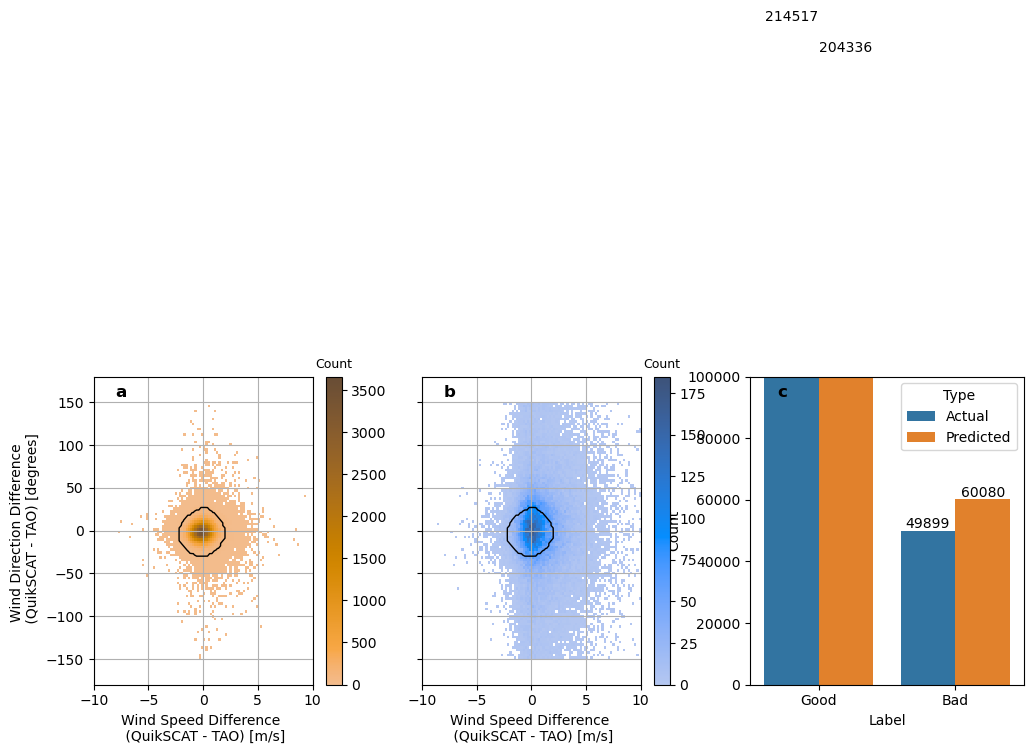

In [12]:
fig,  axes = plt.subplots(nrows = 1, ncols = 3, figsize=(12,4), sharex = False, sharey = False)
labelFS = 12

xedges, yedges = np.linspace(-10,10,101),np.linspace(-150,150,101)
H, xedges, yedges = np.histogram2d(
    df.loc[df["label"]==0, xlabel],
    df.loc[df["label"]==0, ylabel],
    bins=(xedges, yedges)
)
# Meshgrid for plotting
X, Y = np.meshgrid(xedges, yedges) #[:-1], yedges[:-1])


ax = axes[0]
s = sns.histplot( df.loc[df["predicted_label"] == 1], x=xlabel, y = ylabel, bins = (xedges, yedges),
                  color = 'orange', cbar = True, ax = ax)
cbar = s.collections[0].colorbar   # get the colorbar
cbar.ax.set_title("Count", fontsize=labelFS-3)

ax.set_xlim(-10,10)
ax.set_ylim(-180,180)
ax.grid()
ax.text(0.1, 0.95, 'a', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = labelFS)
CS = ax.contour(
    X[:-1,:-1], Y[:-1,:-1], H.T,   # note: transpose to align with seaborn
    levels=[0.5],   # 0.5 ensures "any nonzero bin" gets outlined
    colors='k',
    linewidths=1
)

ax.set_ylabel('Wind Direction Difference \n (QuikSCAT - TAO) [degrees]')
ax.set_xlabel('Wind Speed Difference \n (QuikSCAT - TAO) [m/s]')


axes[1].sharex(axes[0])
axes[1].sharey(axes[0])
ax = axes[1]
s = sns.histplot( df.loc[df["predicted_label"] == 0], x=xlabel, y = ylabel, bins = (xedges, yedges),
                  color = 'dodgerblue', cbar = True, ax = ax)
cbar = s.collections[0].colorbar   # get the colorbar
cbar.ax.set_title("Count", fontsize=labelFS-3)
ax.set_xlim(-10,10)
ax.set_ylim(-180,180)
ax.grid()
ax.text(0.1, 0.95, 'b', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = labelFS)
CS = ax.contour(
    X[:-1,:-1], Y[:-1,:-1], H.T,   # note: transpose to align with seaborn
    levels=[0.5],   # 0.5 ensures "any nonzero bin" gets outlined
    colors='k',
    linewidths=1
)

ax.set_ylabel('')
ax.tick_params(labelleft=False)
ax.set_xlabel('Wind Speed Difference \n (QuikSCAT - TAO) [m/s]')


###################
predicted_label = df['predicted_label'].to_numpy()
dbscan_label = df['label'].to_numpy() + 1

dbscan_good = dbscan_label == 1
dbscan_bad = dbscan_label == 0

pred_good = predicted_label == 1
pred_bad = predicted_label == 0


good_and_predicted_good = np.sum(np.logical_and(dbscan_good, pred_good))
bad_and_predicted_bad = np.sum(np.logical_and(dbscan_bad, pred_bad))

good_but_predicted_bad = np.sum(np.logical_and(dbscan_good, pred_bad))
bad_but_predicted_good = np.sum(np.logical_and(dbscan_bad, pred_good))

countDF = pd.DataFrame({
    'Label': [
        'Good', 'Bad'
    ],
    'Actual': [
        int(np.sum(dbscan_good)),
        int(np.sum(dbscan_bad))
    ],
    'Predicted': [
        int(np.sum(pred_good)),
        int(np.sum(pred_bad))
    ]
})

# melt to long format for seaborn
plotDF = countDF.melt(id_vars='Label', value_vars=['Actual','Predicted'],
                      var_name='Type', value_name='Count')

# # wrap labels
plotDF['Label'] = plotDF['Label'].apply(lambda x: '\n'.join(textwrap.wrap(x, width=12)))

# # --- Plot ---
ax = axes[2]
colors = [plt.cm.tab20c(12), plt.cm.tab20c(13)]
bplot = sns.barplot(plotDF, x='Label', y='Count', hue='Type', #palette= colors,
                    ax = ax)

# add counts on top
for p in bplot.patches:
    height = p.get_height()
    if not np.isnan(height) and height > 0:  # skip empty bars and zero
        ax.text(
            p.get_x() + p.get_width() / 2.,  # center of bar
            height,                          # y position
            f'{int(height)}',                # label
            ha='center', 
            va='bottom', 
            fontsize=10, 
            #weight='bold'
        )
ax.set_ylim(0,100000)

ax.text(0.1, 0.95, 'c', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = labelFS)

# ax = axes[2]
# s = sns.histplot( df.loc[df["label"] == 0], x=xlabel, y = ylabel, bins = (xedges, yedges), 
#                   color = 'dodgerblue', cbar = True, ax = ax)
# ax.set_xlim(-10,10)
# ax.set_ylim(-180,180)
# ax.grid()
# ax.text(0.1, 0.95, 'C', horizontalalignment='left',
#         verticalalignment='center', transform=ax.transAxes,
#         weight = 'heavy', fontsize = labelFS)


# ax.set_xlabel('Wind Speed Difference \n (QuikSCAT - TAO) [m/s]')

# ax = axes[3]
# s = sns.histplot( df.loc[df["label"] == -1], x=xlabel, y = ylabel, bins = (xedges, yedges),
#                   color = 'orange', cbar = True, ax = ax)
# ax.set_xlim(-10,10)
# ax.set_ylim(-180,180)
# ax.grid()
# ax.text(0.1, 0.95, 'D', horizontalalignment='left',
#         verticalalignment='center', transform=ax.transAxes,
#         weight = 'heavy', fontsize = labelFS)
# ax.set_xlabel('Wind Speed Difference \n (QuikSCAT - TAO) [m/s]')


plt.tight_layout()
plt.savefig('goodBadMatchupPredictedOnQuikSCATtrainedOnQuikSCAT.pdf', dpi=100)

In [13]:
plotDF

,Label,Type,Count
0,Good,Actual,214517
1,Bad,Actual,49899
2,Good,Predicted,204336
3,Bad,Predicted,60080


In [14]:
countDF

,Label,Actual,Predicted
0,Good,214517,204336
1,Bad,49899,60080


In [15]:
plt.figure(figsize = (15,5))
import textwrap
countDF['Label'] = countDF['Label'].apply(lambda x: '\n'.join(textwrap.wrap(x, width=15)))
sns.barplot(countDF, x = 'Label', y='Count' )

ValueError: Could not interpret input 'Count'

<Figure size 1500x500 with 0 Axes>

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
y_test = df["label"] + 1
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [ ]:
print(np.sum(y_pred == 1), np.sum(y_pred == 0))

In [ ]:
def getGoodBad(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:    
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        return f' {goodCount:3.0f},{badCount:3.0f}'
    else:
        return ''

def getBadPercent(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    
    if isPresent:
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        
        return badCount
    else:
        return -999

def getCount(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        count = len(subDF) #.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        return count
    else:
        return -999


def getSpeedCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'WSPD_10N (TAO)'
        else:
            TAOlabel = f'mean WSPD_10N {timeWindow}min'
        QSspeed = subDF['WSPD_10N (QuikSCAT)'].to_numpy()
        TAOspeed = subDF[TAOlabel].to_numpy()
        corr = np.corrcoef(QSspeed, TAOspeed)[0,1]
        return corr
    else:
        return -999

def getDirCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'WDIR (TAO)'
        else:
            TAOlabel = f'mean WDIR {timeWindow}min'
        QSdir = subDF['WDIR (QuikSCAT)'].to_numpy()
        TAOdir = subDF[TAOlabel].to_numpy()
        corr = np.corrcoef(QSdir, TAOdir)[0,1]
        return corr
    else:
        return -999

def getXSpeedCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Zonal Wind Speed (TAO)'
        else:
            TAOlabel = f'mean Ux_10N {timeWindow}min'
        QSspeed_x = subDF['Zonal WSPD_10N (QuikSCAT)']
        TAOspeed_x = subDF[TAOlabel]
        corr = np.corrcoef(QSspeed_x, TAOspeed_x)[0,1]
        return corr
    else:
        return -999

def getYSpeedCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
        if timeWindow == 10:
            TAOlabel = 'Meridional Wind Speed (TAO)'
        else:
            TAOlabel = f'mean Vy_10N {timeWindow}min'
    if isPresent:
        QSspeed_y = subDF['Meridional WSPD_10N (QuikSCAT)']
        TAOspeed_y = subDF[TAOlabel]
        corr = np.corrcoef(QSspeed_y, TAOspeed_y)[0,1]
        return corr
    else:
        return -999


goodBad = np.array(['good' for i in range(len(df))])
print(len(goodBad))
mask = df['predicted_label'].isin([0])
goodBad[mask] = 'bad'
df['GoodBad'] = goodBad

In [ ]:
def getSpeedDifference(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'WSPD_10N (TAO)'
        else:
            TAOlabel = f'mean WSPD_10N {timeWindow}min'
        QSspeed = subDF['WSPD_10N (QuikSCAT)'].to_numpy()
        TAOspeed = subDF[TAOlabel].to_numpy()
        corr = np.mean(QSspeed) - np.mean(TAOspeed)
        return corr
    else:
        return -999

def getSpeedRMSE(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'WSPD_10N (TAO)'
        else:
            TAOlabel = f'mean WSPD_10N {timeWindow}min'
        QSspeed = subDF['WSPD_10N (QuikSCAT)'].to_numpy()
        TAOspeed = subDF[TAOlabel].to_numpy()
        corr = np.sqrt(np.mean((QSspeed - TAOspeed)**2))
        return corr
    else:
        return -999


def getSpeedCorrelation(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'WSPD_10N (TAO)'
        else:
            TAOlabel = f'mean WSPD_10N {timeWindow}min'
        QSspeed = subDF['WSPD_10N (QuikSCAT)'].to_numpy()
        TAOspeed = subDF[TAOlabel].to_numpy()
        corr = np.corrcoef(QSspeed, TAOspeed)[0,1]
        return corr
    else:
        return -999

#########################################################################################3

def getDirDifference(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'WDIR (TAO)'
        else:
            TAOlabel = f'mean WDIR {timeWindow}min'
        QSdir = subDF['WDIR (QuikSCAT)'].to_numpy()
        TAOdir = subDF[TAOlabel].to_numpy()
        corr = np.mean(QSdir)- np.mean(TAOdir)
        return corr
    else:
        return -999


def getDirRMSE(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'WDIR (TAO)'
        else:
            TAOlabel = f'mean WDIR {timeWindow}min'
        QSdir = subDF['WDIR (QuikSCAT)'].to_numpy()
        TAOdir = subDF[TAOlabel].to_numpy()
        diff = QSdir - TAOdir
        diff[diff>180] -= 360
        diff[diff<-180] += 360
        corr = np.sqrt(np.mean(diff**2))
        return corr
    else:
        return -999
        
def getDirCorrelation(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'WDIR (TAO)'
        else:
            TAOlabel = f'mean WDIR {timeWindow}min'
        QSdir = subDF['WDIR (QuikSCAT)'].to_numpy()
        TAOdir = subDF[TAOlabel].to_numpy()
        corr = np.corrcoef(QSdir, TAOdir)[0,1]
        return corr
    else:
        return -999



In [ ]:
subDF = df.copy() #df.loc[df['predicted_label'] == 1]
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

import cartopy.crs as ccrs
import cartopy.feature as cfeature 
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

fig, axes = plt.subplots(nrows = 3, 
                       ncols = 2, 
                        figsize = (22*0.9,18*0.8),
                         sharex = True,
                         sharey = True, 
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180),  
                                   "aspect": 2.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)


fontSize = 15
fsz = 12
tickFsz = 10
dotSize = 90
slw = 0.25
cbFs = 12
###################################################################################################################
ax = axes[0,0] 

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
# gridlines = ax.gridlines(draw_labels=True, linewidth=0.5, alpha = 0.5)
# gridlines.xlocator = plt.FixedLocator([150, 180, 210, 240, 270])
# ax.coastlines()

gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = True   
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedDifference(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, 
               edgecolor='black', linewidths=slw, cmap=cm.bwr, vmin= -0.3, vmax= 0.3)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Difference \n (QuikSCAT - TAO) \n [m/s]')

ax.text(0.1, 0.95, 'A.  Mean Wind Speed Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
ax = axes[1,0]

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = False   
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedRMSE(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', 
               linewidths=slw, cmap=cm.Reds, vmin=0.7, vmax=1.2)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('[m/s]')

ax.text(0.1, 0.95, 'B.  RMS Wind Speed Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
ax = axes[2,0]

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = False  
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, subDF)
    #print(corr)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:5.2f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', 
               linewidths=slw, cmap=cm.turbo, vmin=0.5, vmax=1,)
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'C.  Wind Speed Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
###################################################################################################################
ax = axes[0,1] 

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = True  
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirDifference(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', 
               linewidths=slw, cmap=cm.bwr, vmin= -5,vmax = 5)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Difference\n(QuikSCAT - TAO)\n(Anti-clockwise)\n' + r'[$\degree$]')

ax.text(0.1, 0.95, 'D. Mean Wind Direction Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)

###################################################################################################################
ax = axes[1,1]

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = False  
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirRMSE(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', 
               linewidths=slw, cmap=cm.Reds, vmin = 5, vmax = 45)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title(r'[$\degree$]')

ax.text(0.1, 0.95, 'E. RMS Wind Direction Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
ax = axes[2,1]

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = False  
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, subDF)
    #print(corr)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:5.2f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', 
               linewidths=slw, cmap=cm.turbo, vmin=0.5, vmax=1)
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'F.  Wind Direction Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################

plt.subplots_adjust(left = 0.03, right = 1, top =0.93 , bottom = 0.02, wspace=0 , hspace=0.1)

plt.savefig('BasicStats_QuikSCAT_All.pdf', dpi=100)

In [ ]:
subDF = df.loc[df['label'] == 0]
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

import cartopy.crs as ccrs
import cartopy.feature as cfeature 
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

fig, axes = plt.subplots(nrows = 3, 
                       ncols = 2, 
                        figsize = (22*0.9,18*0.8),
                         sharex = True,
                         sharey = True, 
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180),  
                                   "aspect": 2.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)


fontSize = 15
fsz = 12
tickFsz = 10
dotSize = 90
slw = 0.25
cbFs = 12
###################################################################################################################
ax = axes[0,0] 

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
# gridlines = ax.gridlines(draw_labels=True, linewidth=0.5, alpha = 0.5)
# gridlines.xlocator = plt.FixedLocator([150, 180, 210, 240, 270])
# ax.coastlines()

gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = True   
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedDifference(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, 
               edgecolor='black', linewidths=slw, cmap=cm.bwr, vmin= -0.3, vmax= 0.3)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Difference \n (QuikSCAT - TAO) \n [m/s]')

ax.text(0.1, 0.95, 'A.  Mean Wind Speed Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
ax = axes[1,0]

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = False   
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedRMSE(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', 
               linewidths=slw, cmap=cm.Reds, vmin=0.7, vmax=1.2)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('[m/s]')

ax.text(0.1, 0.95, 'B.  RMS Wind Speed Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
ax = axes[2,0]

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = False  
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, subDF)
    #print(corr)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:5.2f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', 
               linewidths=slw, cmap=cm.turbo, vmin=0.5, vmax=1,)
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'C.  Wind Speed Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
###################################################################################################################
ax = axes[0,1] 

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = True  
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirDifference(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', 
               linewidths=slw, cmap=cm.bwr, vmin= -5,vmax = 5)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Difference\n(QuikSCAT - TAO)\n(Anti-clockwise)\n' + r'[$\degree$]')

ax.text(0.1, 0.95, 'D. Mean Wind Direction Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)

###################################################################################################################
ax = axes[1,1]

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = False  
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirRMSE(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', 
               linewidths=slw, cmap=cm.Reds, vmin = 5, vmax = 45)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title(r'[$\degree$]')

ax.text(0.1, 0.95, 'E. RMS Wind Direction Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
ax = axes[2,1]

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = False  
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, subDF)
    #print(corr)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:5.2f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', 
               linewidths=slw, cmap=cm.turbo, vmin=0.5, vmax=1)
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'F.  Wind Direction Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################

plt.subplots_adjust(left = 0.03, right = 1, top =0.93 , bottom = 0.02, wspace=0 , hspace=0.1)
plt.savefig('BasicStats_QuikSCAT_good.pdf', dpi=100)

In [ ]:
subDF = df.loc[df['label'] == -1]
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

import cartopy.crs as ccrs
import cartopy.feature as cfeature 
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

fig, axes = plt.subplots(nrows = 3, 
                       ncols = 2, 
                        figsize = (22*0.9,18*0.8),
                         sharex = True,
                         sharey = True, 
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180),  
                                   "aspect": 2.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)


fontSize = 15
fsz = 12
tickFsz = 10
dotSize = 90
slw = 0.25
cbFs = 12
###################################################################################################################
ax = axes[0,0] 

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
# gridlines = ax.gridlines(draw_labels=True, linewidth=0.5, alpha = 0.5)
# gridlines.xlocator = plt.FixedLocator([150, 180, 210, 240, 270])
# ax.coastlines()

gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = True   
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedDifference(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, 
               edgecolor='black', linewidths=slw, cmap=cm.bwr, vmin= -0.3, vmax= 0.3)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Difference \n (QuikSCAT - TAO) \n [m/s]')

ax.text(0.1, 0.95, 'A.  Mean Wind Speed Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
ax = axes[1,0]

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = False   
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedRMSE(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', 
               linewidths=slw, cmap=cm.Reds, vmin=0.7, vmax=1.2)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('[m/s]')

ax.text(0.1, 0.95, 'B.  RMS Wind Speed Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
ax = axes[2,0]

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = False  
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, subDF)
    #print(corr)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:5.2f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', 
               linewidths=slw, cmap=cm.turbo, vmin=0.5, vmax=1,)
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'C.  Wind Speed Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
###################################################################################################################
ax = axes[0,1] 

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = True  
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirDifference(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', 
               linewidths=slw, cmap=cm.bwr, vmin= -5,vmax = 5)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Difference\n(QuikSCAT - TAO)\n(Anti-clockwise)\n' + r'[$\degree$]')

ax.text(0.1, 0.95, 'D. Mean Wind Direction Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)

###################################################################################################################
ax = axes[1,1]

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = False  
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirRMSE(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', 
               linewidths=slw, cmap=cm.Reds, vmin = 5, vmax = 45)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title(r'[$\degree$]')

ax.text(0.1, 0.95, 'E. RMS Wind Direction Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
ax = axes[2,1]

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = False  
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, subDF)
    #print(corr)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:5.2f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', 
               linewidths=slw, cmap=cm.turbo, vmin=0.5, vmax=1)
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'F.  Wind Direction Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################

plt.subplots_adjust(left = 0.03, right = 1, top =0.93 , bottom = 0.02, wspace=0 , hspace=0.1)

plt.savefig('BasicStats_QuikSCAT_bad.pdf', dpi=100)

In [ ]:
subDF = df.loc[df['predicted_label'] == 1]
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

import cartopy.crs as ccrs
import cartopy.feature as cfeature 
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

fig, axes = plt.subplots(nrows = 3, 
                       ncols = 2, 
                        figsize = (22*0.9,18*0.8),
                         sharex = True,
                         sharey = True, 
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180),  
                                   "aspect": 2.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)


fontSize = 15
fsz = 12
tickFsz = 10
dotSize = 90
slw = 0.25
cbFs = 12
###################################################################################################################
ax = axes[0,0] 

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
# gridlines = ax.gridlines(draw_labels=True, linewidth=0.5, alpha = 0.5)
# gridlines.xlocator = plt.FixedLocator([150, 180, 210, 240, 270])
# ax.coastlines()

gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = True   
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedDifference(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, 
               edgecolor='black', linewidths=slw, cmap=cm.bwr, vmin= -0.3, vmax= 0.3)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Difference \n (QuikSCAT - TAO) \n [m/s]')

ax.text(0.1, 0.95, 'A.  Mean Wind Speed Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
ax = axes[1,0]

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = False   
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedRMSE(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', 
               linewidths=slw, cmap=cm.Reds, vmin=0.7, vmax=1.2)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('[m/s]')

ax.text(0.1, 0.95, 'B.  RMS Wind Speed Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
ax = axes[2,0]

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = False  
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, subDF)
    #print(corr)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:5.2f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', 
               linewidths=slw, cmap=cm.turbo, vmin=0.5, vmax=1,)
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'C.  Wind Speed Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
###################################################################################################################
ax = axes[0,1] 

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = True  
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirDifference(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', 
               linewidths=slw, cmap=cm.bwr, vmin= -5,vmax = 5)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Difference\n(QuikSCAT - TAO)\n(Anti-clockwise)\n' + r'[$\degree$]')

ax.text(0.1, 0.95, 'D. Mean Wind Direction Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)

###################################################################################################################
ax = axes[1,1]

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = False  
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirRMSE(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', 
               linewidths=slw, cmap=cm.Reds, vmin = 5, vmax = 45)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title(r'[$\degree$]')

ax.text(0.1, 0.95, 'E. RMS Wind Direction Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
ax = axes[2,1]

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = False  
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, subDF)
    #print(corr)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:5.2f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', 
               linewidths=slw, cmap=cm.turbo, vmin=0.5, vmax=1)
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'F.  Wind Direction Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################

plt.subplots_adjust(left = 0.03, right = 1, top =0.93 , bottom = 0.02, wspace=0 , hspace=0.1)

plt.savefig('BasicStats_QuikSCAT_PredictedGood.pdf', dpi=100)